# Clustering des Clients - Analyse ML

Ce notebook vise à segmenter les clients en clusters homogènes pour une meilleure compréhension du comportement d'achat.

## Méthodologie
1. Exploration des données clients
2. Feature Engineering
3. Normalisation
4. Réduction de dimensionnalité (PCA)
5. Détermination du nombre optimal de clusters
6. Clustering (K-Means, DBSCAN, Hierarchical)
7. Interprétation et visualisation
8. Sauvegarde du modèle

## 1. Import des bibliothèques

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML - Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# ML - Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

# DBSCAN pour comparaison
from sklearn.neighbors import NearestNeighbors

# Radar chart pour comparer les clusters
from math import pi

# Model persistence
import joblib

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

# Calcul du VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Détection et traitement des outliers (optionnel mais recommandé)
from scipy import stats

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


## 2. Chargement et exploration des données

In [2]:
# Chargement des données
CLEANED_DIR = Path("data/cleaned")
ENRICHED_DIR = Path("data/enriched")

customers = pd.read_csv(CLEANED_DIR / "customers_clean.csv")
products = pd.read_csv(CLEANED_DIR / "products_clean.csv")
orders = pd.read_csv(CLEANED_DIR / "orders_clean.csv", parse_dates=['orderDate', 'requiredDate', 'shippedDate'])
order_details = pd.read_csv(CLEANED_DIR / "order_details_clean.csv")
rfm = pd.read_csv(ENRICHED_DIR / "rfm_analysis.csv")

print(f"📊 Données chargées:")
print(f"   - Clients: {len(customers)} lignes")
print(f"   - Produits: {len(products)} lignes")
print(f"   - Commandes: {len(orders)} lignes")
print(f"   - Détails commandes: {len(order_details)} lignes")
print(f"   - RFM: {len(rfm)} lignes")

📊 Données chargées:
   - Clients: 91 lignes
   - Produits: 77 lignes
   - Commandes: 830 lignes
   - Détails commandes: 2155 lignes
   - RFM: 89 lignes


In [3]:
# Aperçu des données RFM existantes
print("📋 Aperçu RFM:")
display(rfm.head())
print("\n📈 Statistiques RFM:")
display(rfm[['recency', 'frequency', 'monetary']].describe())

📋 Aperçu RFM:


,customerID,recency,frequency,monetary,companyName,country,R_score,F_score,M_score,RFM_score,RFM_total,segment
0,ALFKI,27,6,4273.0000,Alfreds Futterkiste,Germany,2,2,2,222,6,Potential
1,ANATR,63,4,1402.9500,Ana Trujillo Emparedados y helados,Mexico,1,1,1,111,3,Lost
2,ANTON,98,7,7023.9775,Antonio Moreno Taquería,Mexico,1,2,2,122,5,At Risk
3,AROUT,26,13,13390.6500,Around the Horn,UK,2,4,3,243,9,Loyal
4,BERGS,63,18,24927.5775,Berglunds snabbköp,Sweden,1,4,4,144,9,Loyal



📈 Statistiques RFM:


,recency,frequency,monetary
count,89.000000,89.000000,89.000000
mean,51.561798,9.325843,14222.393702
std,87.484278,5.810991,20219.818190
min,0.000000,1.000000,100.800000
25%,8.000000,5.000000,3239.800000
50%,23.000000,8.000000,7048.240000
75%,58.000000,12.000000,16817.097500
max,657.000000,31.000000,110277.305000


## 3. Feature Engineering

Nous allons créer des features additionnelles pour enrichir l'analyse des clients.

In [4]:
# Jointure orders avec order_details pour calculs avancés
orders_full = orders.merge(order_details, on='orderID', how='left')

# Calculs par client
customer_features = orders_full.groupby('customerID').agg({
    'orderID': 'nunique',  # Nombre de commandes
    'productID': 'nunique',  # Diversité produits
    'quantity': 'sum',  # Quantité totale achetée
    'discount': 'mean',  # Réduction moyenne
}).reset_index()

customer_features.columns = ['customerID', 'total_orders', 'product_diversity', 'total_quantity', 'avg_discount']

# Valeur panier moyen
customer_features['avg_basket_size'] = customer_features['total_quantity'] / customer_features['total_orders']

# Temps entre commandes (moyenne)
time_between_orders = orders.groupby('customerID')['orderDate'].apply(
    lambda x: x.sort_values().diff().dt.days.mean() if len(x) > 1 else 0
).reset_index()
time_between_orders.columns = ['customerID', 'avg_days_between_orders']

customer_features = customer_features.merge(time_between_orders, on='customerID', how='left')

# Tendance récente (commandes des 90 derniers jours vs total)
max_date = orders['orderDate'].max()
recent_orders = orders[orders['orderDate'] >= (max_date - pd.Timedelta(days=90))].groupby('customerID').size().reset_index(name='recent_orders')
customer_features = customer_features.merge(recent_orders, on='customerID', how='left')
customer_features['recent_orders'].fillna(0, inplace=True)
customer_features['recent_ratio'] = customer_features['recent_orders'] / customer_features['total_orders']

print("✅ Features créées:")
display(customer_features.head())
print(f"\n📊 Shape: {customer_features.shape}")

✅ Features créées:


,customerID,total_orders,product_diversity,total_quantity,avg_discount,avg_basket_size,avg_days_between_orders,recent_orders,recent_ratio
0,ALFKI,6,11,174,0.087500,29.000000,45.400000,2.0,0.333333
1,ANATR,4,10,63,0.000000,15.750000,177.333333,1.0,0.250000
2,ANTON,7,15,359,0.058824,51.285714,71.166667,0.0,0.000000
3,AROUT,13,24,650,0.023333,50.000000,42.583333,3.0,0.230769
4,BERGS,18,37,1001,0.057692,55.611111,33.470588,2.0,0.111111



📊 Shape: (89, 9)


In [5]:
# Fusion avec RFM
customer_data = rfm[['customerID', 'recency', 'frequency', 'monetary']].merge(
    customer_features, on='customerID', how='left'
)

# Vérification des valeurs manquantes
print("🔍 Valeurs manquantes:")
print(customer_data.isnull().sum())

# Remplissage des valeurs manquantes
customer_data.fillna(0, inplace=True)

print(f"\n✅ Dataset final pour clustering: {customer_data.shape}")
display(customer_data.head(10))

🔍 Valeurs manquantes:
customerID                 0
recency                    0
frequency                  0
monetary                   0
total_orders               0
product_diversity          0
total_quantity             0
avg_discount               0
avg_basket_size            0
avg_days_between_orders    0
recent_orders              0
recent_ratio               0
dtype: int64

✅ Dataset final pour clustering: (89, 12)


,customerID,recency,frequency,monetary,total_orders,product_diversity,total_quantity,avg_discount,avg_basket_size,avg_days_between_orders,recent_orders,recent_ratio
0,ALFKI,27,6,4273.0000,6,11,174,0.087500,29.000000,45.400000,2.0,0.333333
1,ANATR,63,4,1402.9500,4,10,63,0.000000,15.750000,177.333333,1.0,0.250000
2,ANTON,98,7,7023.9775,7,15,359,0.058824,51.285714,71.166667,0.0,0.000000
3,AROUT,26,13,13390.6500,13,24,650,0.023333,50.000000,42.583333,3.0,0.230769
4,BERGS,63,18,24927.5775,18,37,1001,0.057692,55.611111,33.470588,2.0,0.111111
5,BLAUS,7,7,3239.8000,7,12,140,0.000000,20.000000,64.166667,2.0,0.285714
6,BLONP,114,11,18534.0800,11,25,666,0.028846,60.545455,53.600000,0.0,0.000000
7,BOLID,43,3,4232.8500,3,6,190,0.116667,63.333333,265.000000,1.0,0.333333
8,BONAP,0,17,21963.2525,17,34,980,0.072727,57.647059,35.437500,5.0,0.294118
9,BOTTM,12,14,20801.6000,14,27,956,0.084286,68.285714,37.692308,8.0,0.571429


## 4. Analyse exploratoire des features

In [6]:
# Statistiques descriptives
print("📊 Statistiques descriptives:")
display(customer_data.describe())

📊 Statistiques descriptives:


,recency,frequency,monetary,total_orders,product_diversity,total_quantity,avg_discount,avg_basket_size,avg_days_between_orders,recent_orders,recent_ratio
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,51.561798,9.325843,14222.393702,9.325843,18.932584,576.595506,0.042930,46.702237,81.883792,2.325843,0.249247
std,87.484278,5.810991,20219.818190,5.810991,11.052352,831.845740,0.040250,29.835442,64.074510,2.032549,0.181100
min,0.000000,1.000000,100.800000,1.000000,2.000000,11.000000,0.000000,8.400000,0.000000,0.000000,0.000000
25%,8.000000,5.000000,3239.800000,5.000000,10.000000,133.000000,0.000000,26.400000,45.000000,1.000000,0.111111
50%,23.000000,8.000000,7048.240000,8.000000,17.000000,345.000000,0.041667,42.166667,65.222222,2.000000,0.250000
75%,58.000000,12.000000,16817.097500,12.000000,25.000000,792.000000,0.073077,60.888889,95.600000,3.000000,0.333333
max,657.000000,31.000000,110277.305000,31.000000,56.000000,4958.000000,0.140000,159.935484,506.000000,9.000000,0.750000


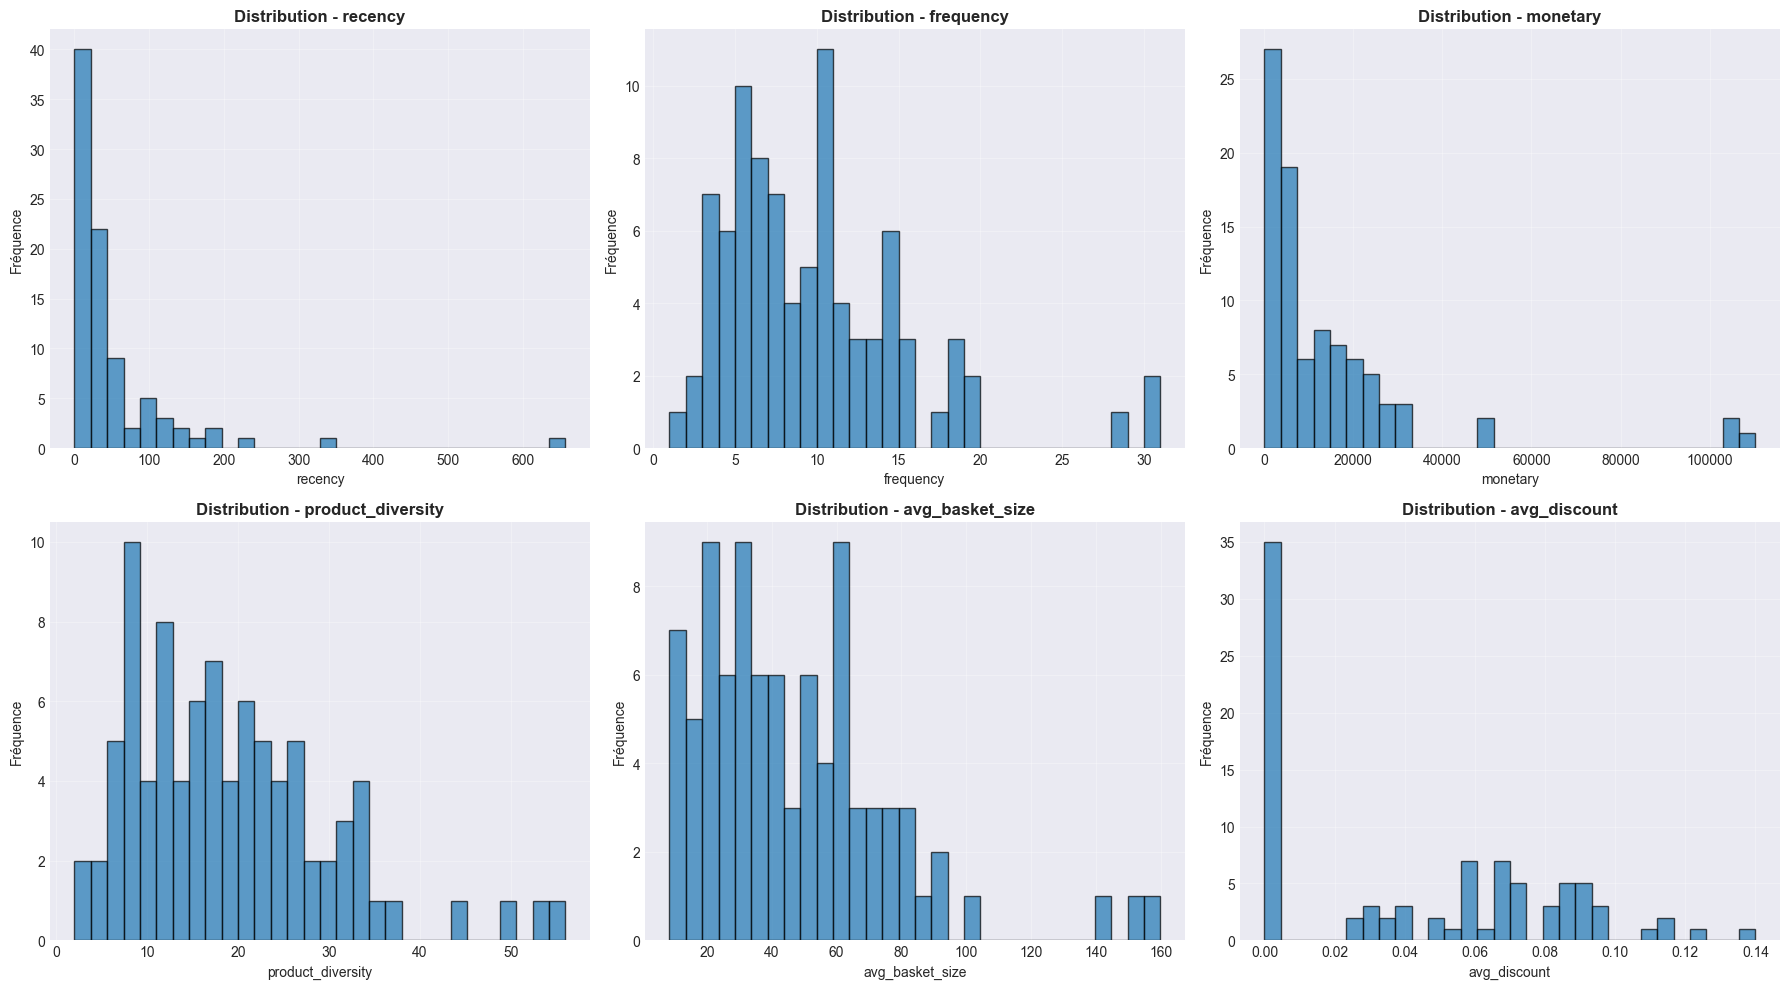

In [7]:
# Distribution des features
features_to_plot = ['recency', 'frequency', 'monetary', 'product_diversity', 'avg_basket_size', 'avg_discount']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(features_to_plot):
    axes[idx].hist(customer_data[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution - {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fréquence')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

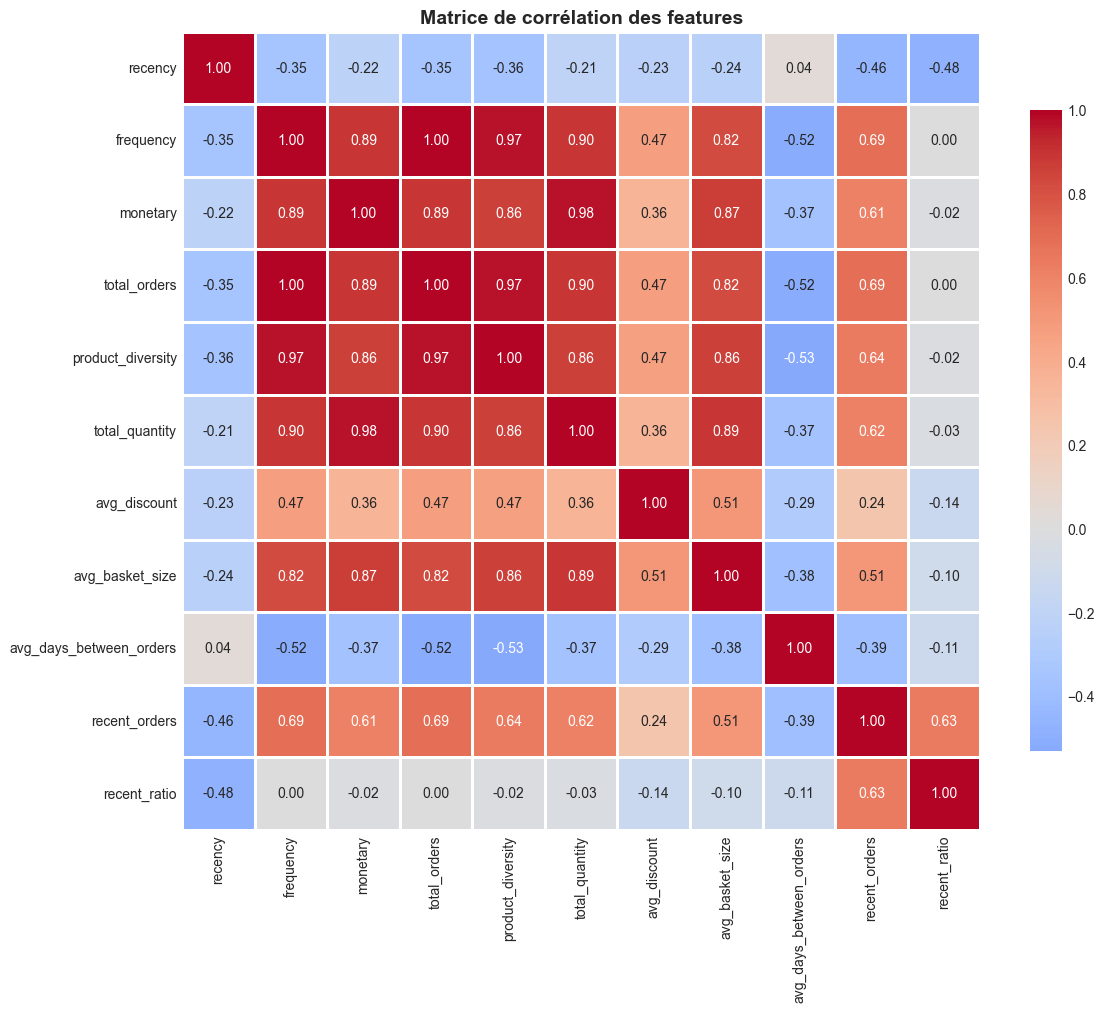


🔍 Corrélations fortes (|r| > 0.7):
frequency          monetary             0.891765
                   product_diversity    0.966939
                   total_quantity       0.896398
                   avg_basket_size      0.822852
monetary           product_diversity    0.859031
                   total_quantity       0.975633
                   avg_basket_size      0.870853
product_diversity  total_quantity       0.858398
                   avg_basket_size      0.858194
total_quantity     avg_basket_size      0.890316
dtype: float64


In [8]:
# Matrice de corrélation
features_for_clustering = customer_data.select_dtypes(include=[np.number]).drop('customerID', axis=1, errors='ignore')

plt.figure(figsize=(12, 10))
correlation_matrix = features_for_clustering.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation des features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Corrélations fortes (|r| > 0.7):")
high_corr = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]
high_corr = high_corr[high_corr != 1.0].stack().drop_duplicates()
if len(high_corr) > 0:
    print(high_corr)
else:
    print("Aucune corrélation forte détectée")

## 4.5. Analyse de la multicolinéarité et sélection de features

📊 Variance Inflation Factor (VIF):
   (VIF > 10 = multicolinéarité forte, VIF > 5 = à surveiller)


,Feature,VIF
1,frequency,inf
3,total_orders,inf
4,product_diversity,113.239929
5,total_quantity,44.226236
2,monetary,32.379118
7,avg_basket_size,32.099111
9,recent_orders,15.970565
10,recent_ratio,8.920303
6,avg_discount,4.094257
8,avg_days_between_orders,2.517875


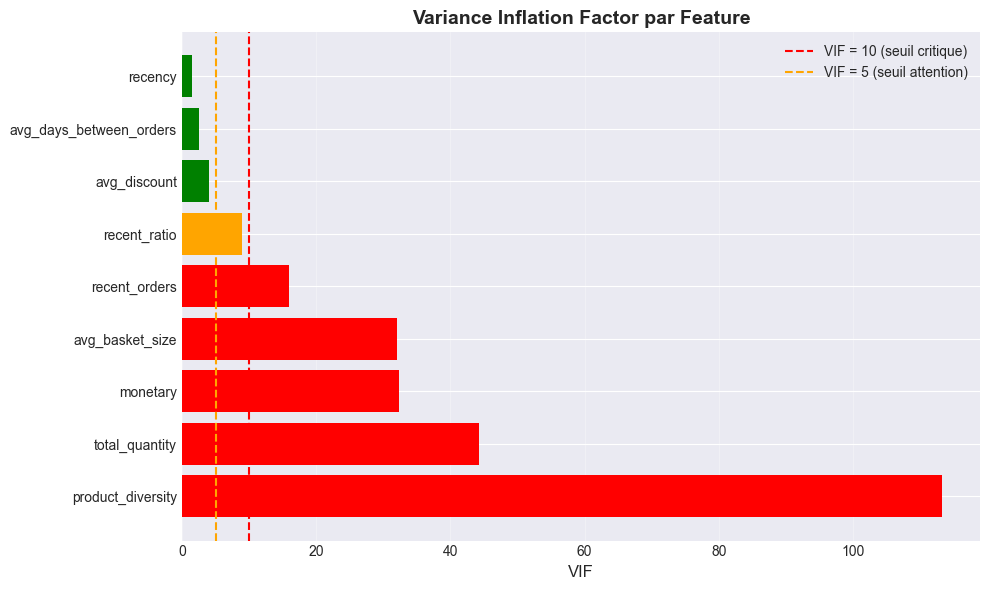

In [9]:
# Sélection des features pour le clustering
feature_columns = features_for_clustering.columns.tolist()

# Calcul des VIF pour chaque feature
vif_data = pd.DataFrame()
vif_data["Feature"] = feature_columns
vif_data["VIF"] = [variance_inflation_factor(features_for_clustering.values, i) 
                   for i in range(len(feature_columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("📊 Variance Inflation Factor (VIF):")
print("   (VIF > 10 = multicolinéarité forte, VIF > 5 = à surveiller)")
display(vif_data)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(vif_data['Feature'], vif_data['VIF'], color=['red' if x > 10 else 'orange' if x > 5 else 'green' for x in vif_data['VIF']])
plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10 (seuil critique)')
plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5 (seuil attention)')
plt.xlabel('VIF', fontsize=12)
plt.title('Variance Inflation Factor par Feature', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [10]:
# Liste recommandée basée sur l'analyse
selected_features = [
    'recency',           # RFM - Récence
    'frequency',         # RFM - Fréquence (on garde celle-ci, pas total_orders)
    'monetary',          # RFM - Montant
    'product_diversity', # Diversité des achats
    'avg_discount',      # Comportement réduction
    'avg_days_between_orders',  # Régularité
    'recent_ratio'       # Tendance récente
]

# Supprimer les features non disponibles
selected_features = [f for f in selected_features if f in feature_columns]

print(f"✅ Features sélectionnées pour le clustering: {len(selected_features)}")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i}. {feat}")

# Mise à jour du dataset
X_final = customer_data[selected_features].copy()

print(f"\n📊 Nouvelles dimensions: {X_final.shape}")
print(f"\n🔍 Statistiques des features sélectionnées:")
display(X_final.describe())

✅ Features sélectionnées pour le clustering: 7
   1. recency
   2. frequency
   3. monetary
   4. product_diversity
   5. avg_discount
   6. avg_days_between_orders
   7. recent_ratio

📊 Nouvelles dimensions: (89, 7)

🔍 Statistiques des features sélectionnées:


,recency,frequency,monetary,product_diversity,avg_discount,avg_days_between_orders,recent_ratio
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,51.561798,9.325843,14222.393702,18.932584,0.042930,81.883792,0.249247
std,87.484278,5.810991,20219.818190,11.052352,0.040250,64.074510,0.181100
min,0.000000,1.000000,100.800000,2.000000,0.000000,0.000000,0.000000
25%,8.000000,5.000000,3239.800000,10.000000,0.000000,45.000000,0.111111
50%,23.000000,8.000000,7048.240000,17.000000,0.041667,65.222222,0.250000
75%,58.000000,12.000000,16817.097500,25.000000,0.073077,95.600000,0.333333
max,657.000000,31.000000,110277.305000,56.000000,0.140000,506.000000,0.750000


### 4.5.1. Optimisation des features avant clustering

**Améliorations appliquées :**
1. **Suppression de product_diversity** : corrélation trop forte avec frequency (0.97)
2. **Transformation log de monetary** : réduction de l'impact des outliers extrêmes

In [11]:
# 1. Suppression de product_diversity (corrélation 0.97 avec frequency)
if 'product_diversity' in selected_features:
    selected_features.remove('product_diversity')
    print("✅ product_diversity supprimée (multicolinéarité avec frequency)")

# 2. Transformation logarithmique de monetary
# On ajoute 1 pour éviter log(0) si jamais il y a des valeurs nulles
customer_data['monetary_log'] = np.log1p(customer_data['monetary'])

# Remplacement de monetary par monetary_log dans les features
if 'monetary' in selected_features:
    idx = selected_features.index('monetary')
    selected_features[idx] = 'monetary_log'
    print("✅ monetary transformée en échelle logarithmique (monetary_log)")

print(f"\n📊 Features optimisées: {len(selected_features)}")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i}. {feat}")

# Mise à jour du dataset avec les features optimisées
X_final = customer_data[selected_features].copy()

print(f"\n📊 Nouvelles dimensions: {X_final.shape}")
print(f"\n🔍 Statistiques des features optimisées:")
display(X_final.describe())

✅ product_diversity supprimée (multicolinéarité avec frequency)
✅ monetary transformée en échelle logarithmique (monetary_log)

📊 Features optimisées: 6
   1. recency
   2. frequency
   3. monetary_log
   4. avg_discount
   5. avg_days_between_orders
   6. recent_ratio

📊 Nouvelles dimensions: (89, 6)

🔍 Statistiques des features optimisées:


,recency,frequency,monetary_log,avg_discount,avg_days_between_orders,recent_ratio
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,51.561798,9.325843,8.869424,0.042930,81.883792,0.249247
std,87.484278,5.810991,1.264955,0.040250,64.074510,0.181100
min,0.000000,1.000000,4.623010,0.000000,0.000000,0.000000
25%,8.000000,5.000000,8.083575,0.000000,45.000000,0.111111
50%,23.000000,8.000000,8.860675,0.041667,65.222222,0.250000
75%,58.000000,12.000000,9.730211,0.073077,95.600000,0.333333
max,657.000000,31.000000,11.610762,0.140000,506.000000,0.750000


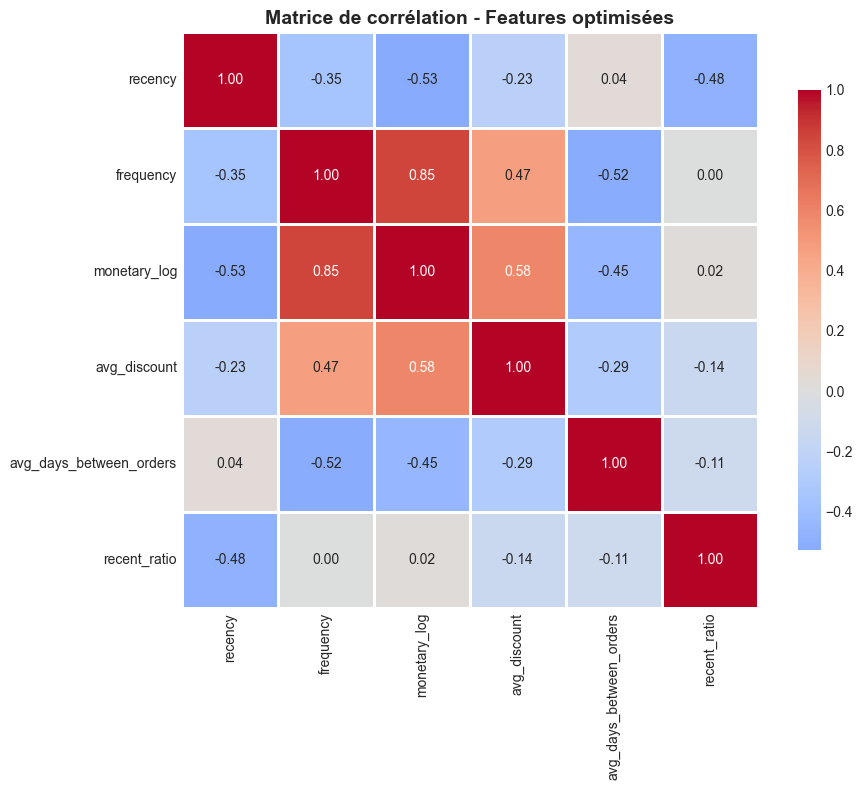


🔍 Corrélations > 0.7 dans les features optimisées:
frequency  monetary_log    0.848325
dtype: float64

📊 Comparaison monetary avant/après transformation log:
   Avant (monetary) - Médiane: 7048.24, Max: 110277.30
   Après (log)      - Médiane: 8.86, Max: 11.61
   → Réduction du ratio max/médiane: 15.6x → 1.3x


In [12]:
# Vérification de la corrélation après optimisation
plt.figure(figsize=(10, 8))
correlation_optimized = X_final.corr()
sns.heatmap(correlation_optimized, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation - Features optimisées', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Vérification : corrélations fortes restantes
print("\n🔍 Corrélations > 0.7 dans les features optimisées:")
high_corr_optimized = correlation_optimized[(correlation_optimized > 0.7) | (correlation_optimized < -0.7)]
high_corr_optimized = high_corr_optimized[high_corr_optimized != 1.0].stack().drop_duplicates()
if len(high_corr_optimized) > 0:
    print(high_corr_optimized)
else:
    print("✅ Aucune corrélation forte détectée - Features bien décorrélées !")

# Comparaison avant/après transformation log
print("\n📊 Comparaison monetary avant/après transformation log:")
print(f"   Avant (monetary) - Médiane: {customer_data['monetary'].median():.2f}, Max: {customer_data['monetary'].max():.2f}")
print(f"   Après (log)      - Médiane: {customer_data['monetary_log'].median():.2f}, Max: {customer_data['monetary_log'].max():.2f}")
print(f"   → Réduction du ratio max/médiane: {customer_data['monetary'].max()/customer_data['monetary'].median():.1f}x → {customer_data['monetary_log'].max()/customer_data['monetary_log'].median():.1f}x")

In [13]:
# Méthode Z-score pour identifier les outliers extrêmes
z_scores = np.abs(stats.zscore(X_final))
outliers_mask = (z_scores > 3).any(axis=1)

print(f"📊 Outliers détectés (Z-score > 3): {outliers_mask.sum()} clients ({outliers_mask.sum()/len(X_final)*100:.1f}%)")

if outliers_mask.sum() > 0:
    print(f"\n💡 Options:")
    print(f"   1. Les garder (RobustScaler gérera)")
    print(f"   2. Les traiter avec winsorization (cap aux percentiles)")
    print(f"   3. Les analyser séparément")
    
    # Affichage des outliers
    outlier_customers = customer_data[outliers_mask][['customerID', 'recency', 'frequency', 'monetary']]
    print(f"\n🔍 Exemples de clients outliers:")
    display(outlier_customers.head(10))

# Pour ce projet, on garde les outliers et on utilise RobustScaler
print(f"\n✅ Décision: Conservation des outliers + utilisation de RobustScaler")

📊 Outliers détectés (Z-score > 3): 6 clients (6.7%)

💡 Options:
   1. Les garder (RobustScaler gérera)
   2. Les traiter avec winsorization (cap aux percentiles)
   3. Les analyser séparément

🔍 Exemples de clients outliers:


,customerID,recency,frequency,monetary
12,CENTC,657,1,100.8000
19,ERNSH,1,30,104874.9785
31,GROSR,139,2,1488.7000
41,LAZYK,349,2,357.0000
60,QUICK,22,28,110277.3050
68,SAVEA,5,31,104361.9500



✅ Décision: Conservation des outliers + utilisation de RobustScaler


## 5. Normalisation des données

Nous utilisons RobustScaler qui est plus robuste aux outliers que StandardScaler.

In [14]:
X = X_final.copy()  # Utilise les features sélectionnées
feature_names = X.columns.tolist()  # Récupère les noms des features sélectionnées

print(f"📊 Features utilisées pour le clustering: {len(feature_names)}")
print(feature_names)

# Normalisation
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

print("\n✅ Données normalisées")
display(X_scaled_df.head())
print(f"\nShape: {X_scaled_df.shape}")

📊 Features utilisées pour le clustering: 6
['recency', 'frequency', 'monetary_log', 'avg_discount', 'avg_days_between_orders', 'recent_ratio']

✅ Données normalisées


,recency,frequency,monetary_log,avg_discount,avg_days_between_orders,recent_ratio
0,0.08,-0.285714,-0.303874,0.627193,-0.391744,0.375000
1,0.80,-0.571429,-0.979956,-0.570175,2.215635,0.000000
2,1.50,-0.142857,-0.002094,0.234778,0.117479,-1.125000
3,0.06,0.714286,0.389711,-0.250877,-0.447409,-0.086538
4,0.80,1.428571,0.767076,0.219298,-0.627503,-0.625000



Shape: (89, 6)


## 6. Analyse en Composantes Principales (PCA)

Réduction de dimensionnalité pour visualisation et éventuellement pour le clustering.

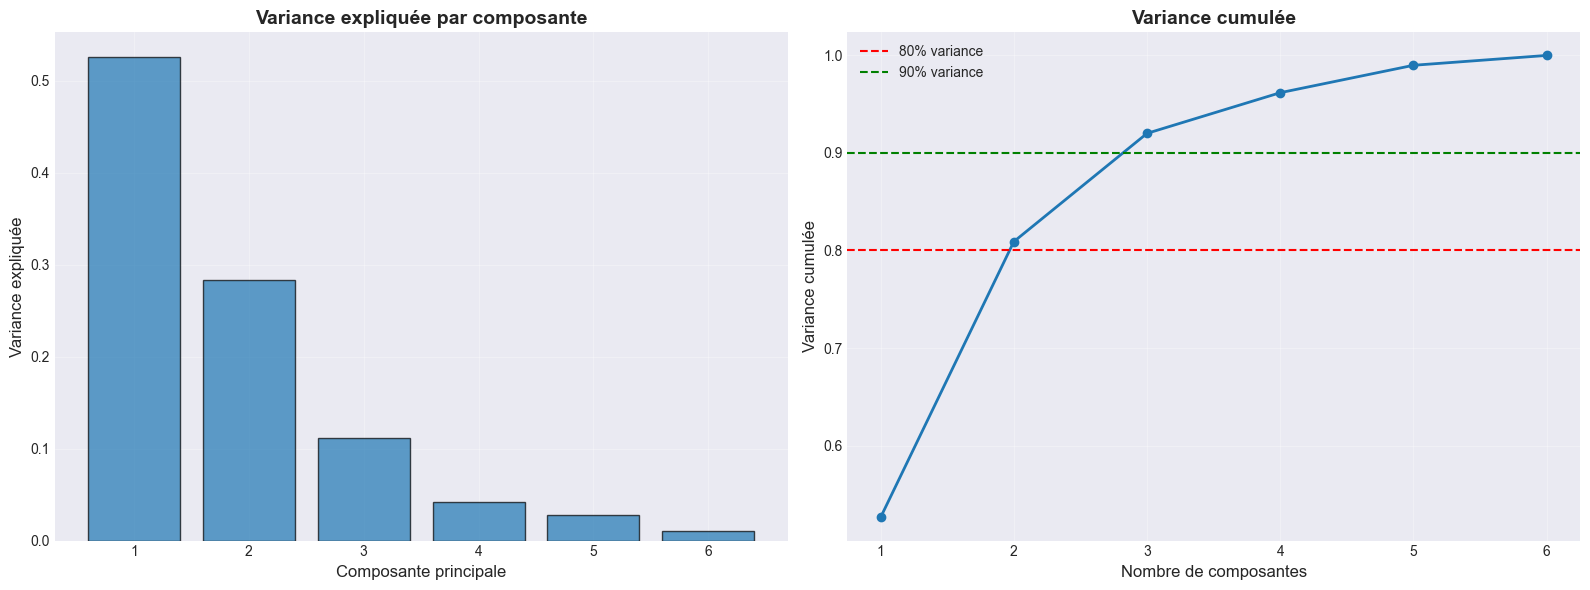


📊 Nombre de composantes pour:
   - 80% de variance: 2 composantes
   - 90% de variance: 3 composantes


In [15]:
# PCA pour déterminer la variance expliquée
pca_full = PCA()
pca_full.fit(X_scaled)

# Variance expliquée
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Variance par composante
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Composante principale', fontsize=12)
ax1.set_ylabel('Variance expliquée', fontsize=12)
ax1.set_title('Variance expliquée par composante', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Variance cumulée
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)
ax2.axhline(y=0.80, color='r', linestyle='--', label='80% variance')
ax2.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
ax2.set_xlabel('Nombre de composantes', fontsize=12)
ax2.set_ylabel('Variance cumulée', fontsize=12)
ax2.set_title('Variance cumulée', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Nombre de composantes pour 80% et 90% de variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"\n📊 Nombre de composantes pour:")
print(f"   - 80% de variance: {n_components_80} composantes")
print(f"   - 90% de variance: {n_components_90} composantes")

In [16]:
# Application PCA avec variance optimale (80%)
n_components = n_components_80
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)], index=X.index)

print(f"✅ PCA appliquée avec {n_components} composantes")
print(f"   Variance totale expliquée: {pca.explained_variance_ratio_.sum():.2%}")
display(X_pca_df.head())

✅ PCA appliquée avec 2 composantes
   Variance totale expliquée: 80.91%


,PC1,PC2
0,-0.500780,-0.227377
1,1.074521,2.059149
2,1.070361,-0.523501
3,-0.784701,-0.711416
4,-0.388030,-1.575764


📊 Contribution des features aux composantes:


,PC1,PC2
recency,0.878,-0.340
frequency,-0.246,-0.347
monetary_log,-0.284,-0.248
avg_discount,-0.104,-0.140
avg_days_between_orders,0.183,0.819
recent_ratio,-0.207,0.108


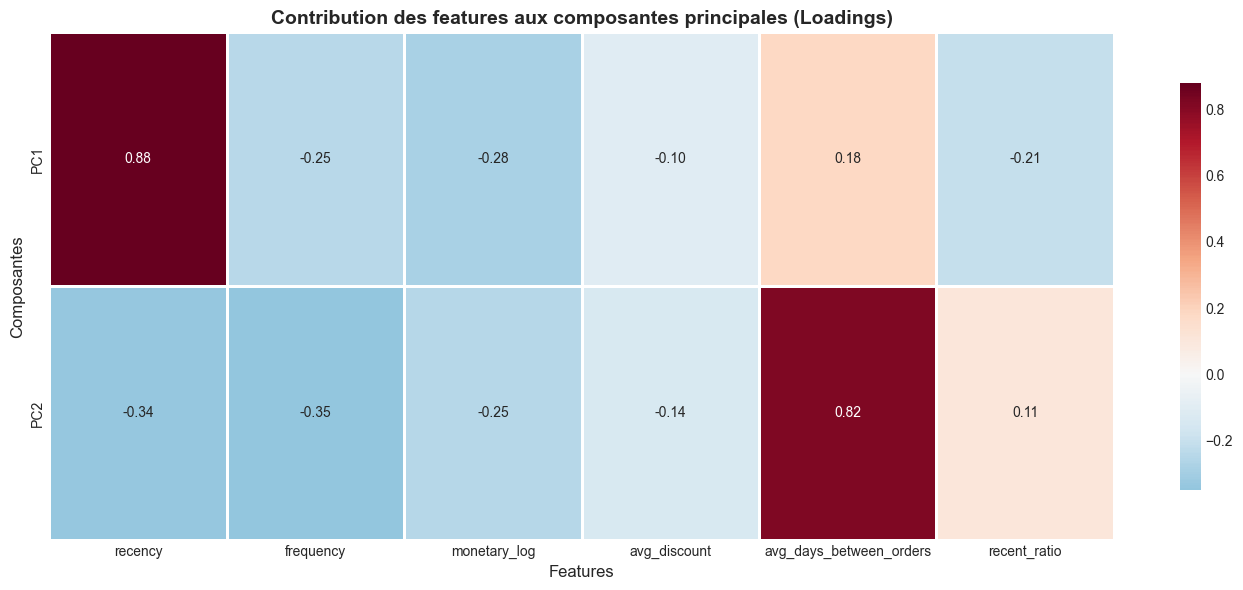

In [17]:
# Contribution des features aux composantes principales
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=feature_names
)

print("📊 Contribution des features aux composantes:")
display(components_df.round(3))

# Visualisation des loadings
plt.figure(figsize=(14, 6))
sns.heatmap(components_df.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            cbar_kws={"shrink": 0.8}, linewidths=1)
plt.title('Contribution des features aux composantes principales (Loadings)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Composantes', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Détermination du nombre optimal de clusters

Nous allons utiliser plusieurs métriques:
- Méthode du coude (Elbow)
- Score Silhouette
- Davies-Bouldin Score
- Calinski-Harabasz Score

In [18]:
# Test avec données normalisées ET données PCA
datasets = {
    'Données normalisées': X_scaled,
    'Données PCA': X_pca
}

results = {}

for dataset_name, X_data in datasets.items():
    print(f"\n{'='*60}")
    print(f"Évaluation sur: {dataset_name}")
    print(f"{'='*60}")
    
    inertias = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    K_range = range(2, 11)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_data)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_data, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X_data, labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(X_data, labels))
    
    results[dataset_name] = {
        'inertias': inertias,
        'silhouette': silhouette_scores,
        'davies_bouldin': davies_bouldin_scores,
        'calinski_harabasz': calinski_harabasz_scores
    }
    
    # Affichage du meilleur score
    best_k_silhouette = K_range[np.argmax(silhouette_scores)]
    best_k_davies = K_range[np.argmin(davies_bouldin_scores)]
    best_k_calinski = K_range[np.argmax(calinski_harabasz_scores)]
    
    print(f"\n📊 Meilleurs K selon les métriques:")
    print(f"   - Silhouette Score: K={best_k_silhouette} (score={max(silhouette_scores):.3f})")
    print(f"   - Davies-Bouldin: K={best_k_davies} (score={min(davies_bouldin_scores):.3f})")
    print(f"   - Calinski-Harabasz: K={best_k_calinski} (score={max(calinski_harabasz_scores):.0f})")


Évaluation sur: Données normalisées



📊 Meilleurs K selon les métriques:
   - Silhouette Score: K=2 (score=0.716)
   - Davies-Bouldin: K=2 (score=0.516)
   - Calinski-Harabasz: K=10 (score=56)

Évaluation sur: Données PCA

📊 Meilleurs K selon les métriques:
   - Silhouette Score: K=2 (score=0.765)
   - Davies-Bouldin: K=2 (score=0.470)
   - Calinski-Harabasz: K=10 (score=137)


In [19]:
# Visualisation comparative
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Méthode du coude (Inertia)', 'Silhouette Score', 
                    'Davies-Bouldin Score (↓ meilleur)', 'Calinski-Harabasz Score'),
    vertical_spacing=0.12,
    horizontal_spacing=0.10
)

colors = {'Données normalisées': 'blue', 'Données PCA': 'red'}

for dataset_name, metrics in results.items():
    color = colors[dataset_name]
    
    # Inertia
    fig.add_trace(
        go.Scatter(x=list(K_range), y=metrics['inertias'], 
                   mode='lines+markers', name=dataset_name, 
                   line=dict(color=color), showlegend=True),
        row=1, col=1
    )
    
    # Silhouette
    fig.add_trace(
        go.Scatter(x=list(K_range), y=metrics['silhouette'], 
                   mode='lines+markers', name=dataset_name, 
                   line=dict(color=color), showlegend=False),
        row=1, col=2
    )
    
    # Davies-Bouldin
    fig.add_trace(
        go.Scatter(x=list(K_range), y=metrics['davies_bouldin'], 
                   mode='lines+markers', name=dataset_name, 
                   line=dict(color=color), showlegend=False),
        row=2, col=1
    )
    
    # Calinski-Harabasz
    fig.add_trace(
        go.Scatter(x=list(K_range), y=metrics['calinski_harabasz'], 
                   mode='lines+markers', name=dataset_name, 
                   line=dict(color=color), showlegend=False),
        row=2, col=2
    )

fig.update_xaxes(title_text="Nombre de clusters (K)", row=2, col=1)
fig.update_xaxes(title_text="Nombre de clusters (K)", row=2, col=2)

fig.update_layout(height=700, title_text="Métriques d'évaluation du clustering", 
                  title_font_size=16, title_x=0.5)
fig.show()

## 8. Application du clustering K-Means

Basé sur les métriques, nous allons tester plusieurs valeurs de K.

In [20]:
# Choix du nombre de clusters (à ajuster selon les résultats ci-dessus)
optimal_k = 3  # Ajustez cette valeur selon vos observations

print(f"🎯 Clustering avec K={optimal_k}")

# Clustering sur données normalisées
kmeans_scaled = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_scaled = kmeans_scaled.fit_predict(X_scaled)

# Clustering sur données PCA
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Ajout des clusters au dataset
customer_data['cluster_scaled'] = clusters_scaled
customer_data['cluster_pca'] = clusters_pca

print(f"\n✅ Clustering effectué")
print(f"\n📊 Distribution des clusters (données normalisées):")
print(customer_data['cluster_scaled'].value_counts().sort_index())
print(f"\n📊 Distribution des clusters (données PCA):")
print(customer_data['cluster_pca'].value_counts().sort_index())

🎯 Clustering avec K=3

✅ Clustering effectué

📊 Distribution des clusters (données normalisées):
cluster_scaled
0    30
1     2
2    57
Name: count, dtype: int64

📊 Distribution des clusters (données PCA):
cluster_pca
0    30
1     2
2    57
Name: count, dtype: int64


In [21]:
# Scores de qualité
print("\n📈 Scores de qualité du clustering:")
print("\nDonnées normalisées:")
print(f"   - Silhouette Score: {silhouette_score(X_scaled, clusters_scaled):.3f}")
print(f"   - Davies-Bouldin Score: {davies_bouldin_score(X_scaled, clusters_scaled):.3f}")
print(f"   - Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, clusters_scaled):.0f}")

print("\nDonnées PCA:")
print(f"   - Silhouette Score: {silhouette_score(X_pca, clusters_pca):.3f}")
print(f"   - Davies-Bouldin Score: {davies_bouldin_score(X_pca, clusters_pca):.3f}")
print(f"   - Calinski-Harabasz Score: {calinski_harabasz_score(X_pca, clusters_pca):.0f}")


📈 Scores de qualité du clustering:

Données normalisées:
   - Silhouette Score: 0.308
   - Davies-Bouldin Score: 1.061
   - Calinski-Harabasz Score: 43

Données PCA:
   - Silhouette Score: 0.430
   - Davies-Bouldin Score: 0.825
   - Calinski-Harabasz Score: 67


In [22]:
# Analyse détaillée des clusters - Identification des outliers
print("="*80)
print("ANALYSE DÉTAILLÉE DES CLUSTERS")
print("="*80)

for cluster_id in sorted(customer_data['cluster_scaled'].unique()):
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - {(customer_data['cluster_scaled'] == cluster_id).sum()} clients")
    print(f"{'='*80}")
    
    # Clients du cluster
    cluster_customers = customer_data[customer_data['cluster_scaled'] == cluster_id][
        ['customerID', 'recency', 'frequency', 'monetary', 'monetary_log']
    ].sort_values('monetary', ascending=False)
    
    print("\n🔍 Clients du cluster:")
    display(cluster_customers)
    
    # Statistiques du cluster
    print(f"\n📊 Statistiques du cluster {cluster_id}:")
    stats = cluster_customers[['recency', 'frequency', 'monetary']].describe()
    display(stats)
    
    # Comparaison avec la moyenne générale
    print(f"\n📈 Comparaison avec la moyenne générale:")
    print(f"   Recency   : {cluster_customers['recency'].mean():.1f} jours (général: {customer_data['recency'].mean():.1f})")
    print(f"   Frequency : {cluster_customers['frequency'].mean():.1f} commandes (général: {customer_data['frequency'].mean():.1f})")
    print(f"   Monetary  : ${cluster_customers['monetary'].mean():.0f} (général: ${customer_data['monetary'].mean():.0f})")
    
    # Ratio vs moyenne
    if customer_data['monetary'].mean() > 0:
        ratio = cluster_customers['monetary'].mean() / customer_data['monetary'].mean()
        print(f"   → Valeur monétaire {ratio:.1f}x la moyenne générale")

print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")

ANALYSE DÉTAILLÉE DES CLUSTERS

CLUSTER 0 - 30 clients

🔍 Clients du cluster:


,customerID,recency,frequency,monetary,monetary_log
21,FOLIG,135,5,11666.9000,9.364597
2,ANTON,98,7,7023.9775,8.857227
78,TRADH,107,6,6850.6640,8.832247
67,SANTG,26,6,5735.1500,8.654544
57,PRINI,28,5,5044.9400,8.526339
50,MORGK,55,5,5042.2000,8.525796
76,TOMSP,44,6,4778.1400,8.472016
55,PERIC,1,6,4242.2000,8.353073
7,BOLID,43,3,4232.8500,8.350867
20,FAMIA,187,7,4107.5500,8.320825



📊 Statistiques du cluster 0:


,recency,frequency,monetary
count,30.000000,30.000000,30.00000
mean,71.166667,4.633333,3384.06480
std,60.489431,1.325697,2358.41115
min,1.000000,2.000000,522.50000
25%,27.250000,3.250000,1552.07500
50%,49.500000,5.000000,3124.31625
75%,106.000000,5.750000,4239.86250
max,240.000000,7.000000,11666.90000



📈 Comparaison avec la moyenne générale:
   Recency   : 71.2 jours (général: 51.6)
   Frequency : 4.6 commandes (général: 9.3)
   Monetary  : $3384 (général: $14222)
   → Valeur monétaire 0.2x la moyenne générale

CLUSTER 1 - 2 clients

🔍 Clients du cluster:


,customerID,recency,frequency,monetary,monetary_log
41,LAZYK,349,2,357.0,5.880533
12,CENTC,657,1,100.8,4.623010



📊 Statistiques du cluster 1:


,recency,frequency,monetary
count,2.000000,2.000000,2.000000
mean,503.000000,1.500000,228.900000
std,217.788889,0.707107,181.160757
min,349.000000,1.000000,100.800000
25%,426.000000,1.250000,164.850000
50%,503.000000,1.500000,228.900000
75%,580.000000,1.750000,292.950000
max,657.000000,2.000000,357.000000



📈 Comparaison avec la moyenne générale:
   Recency   : 503.0 jours (général: 51.6)
   Frequency : 1.5 commandes (général: 9.3)
   Monetary  : $229 (général: $14222)
   → Valeur monétaire 0.0x la moyenne générale

CLUSTER 2 - 57 clients

🔍 Clients du cluster:


,customerID,recency,frequency,monetary,monetary_log
60,QUICK,22,28,110277.3050,11.610762
19,ERNSH,1,30,104874.9785,11.560534
68,SAVEA,5,31,104361.9500,11.555630
62,RATTC,0,18,51097.8005,10.841516
35,HUNGO,6,19,49979.9050,10.819396
32,HANAR,9,14,32841.3700,10.399475
37,KOENE,20,14,30908.3840,10.338815
22,FOLKO,9,19,29567.5625,10.294467
49,MEREP,188,13,28872.1900,10.270669
86,WHITC,5,14,27363.6050,10.217006



📊 Statistiques du cluster 2:


,recency,frequency,monetary
count,57.000000,57.000000,57.000000
mean,25.403509,12.070175,20417.777114
std,33.230719,5.522227,23034.579299
min,0.000000,4.000000,1814.800000
25%,7.000000,9.000000,7176.215000
50%,14.000000,10.000000,15177.462500
75%,29.000000,14.000000,23128.860000
max,188.000000,31.000000,110277.305000



📈 Comparaison avec la moyenne générale:
   Recency   : 25.4 jours (général: 51.6)
   Frequency : 12.1 commandes (général: 9.3)
   Monetary  : $20418 (général: $14222)
   → Valeur monétaire 1.4x la moyenne générale

CONCLUSION


## 9. Interprétation des clusters

In [23]:
# Profil des clusters (utilisons le clustering sur données normalisées)
cluster_column = 'cluster_scaled'  # Changez en 'cluster_pca' si vous préférez

cluster_profiles = customer_data.groupby(cluster_column)[feature_columns].mean()

print(f"\n📊 Profils des clusters (moyennes):")
display(cluster_profiles.round(2))

# Taille des clusters
cluster_sizes = customer_data.groupby(cluster_column).size()
print(f"\n📏 Taille des clusters:")
print(cluster_sizes)


📊 Profils des clusters (moyennes):


,recency,frequency,monetary,total_orders,product_diversity,total_quantity,avg_discount,avg_basket_size,avg_days_between_orders,recent_orders,recent_ratio
cluster_scaled,,,,,,,,,,,
0,71.17,4.63,3384.06,4.63,9.83,140.43,0.02,29.08,138.51,1.00,0.21
1,503.00,1.50,228.90,1.50,2.00,15.50,0.00,10.50,31.00,0.00,0.00
2,25.40,12.07,20417.78,12.07,24.32,825.84,0.06,57.25,53.87,3.11,0.28



📏 Taille des clusters:
cluster_scaled
0    30
1     2
2    57
dtype: int64


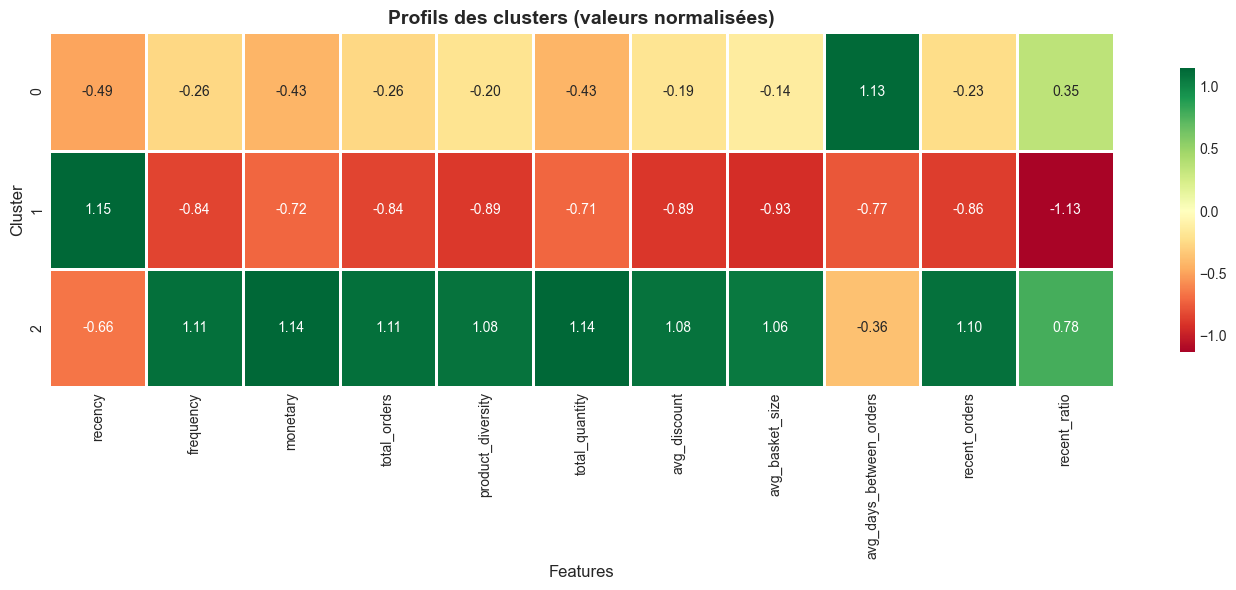

In [24]:
# Heatmap des profils de clusters
# Normalisation pour comparaison visuelle
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_profiles_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Profils des clusters (valeurs normalisées)', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
# Interprétation textuelle des clusters
def interpret_cluster(cluster_id, profile):
    """Génère une interprétation textuelle du cluster"""
    interpretation = f"\n🔍 Cluster {cluster_id}:\n"
    
    # Recency
    if profile['recency'] < 30:
        interpretation += "   - Clients actifs récemment\n"
    elif profile['recency'] < 60:
        interpretation += "   - Clients moyennement actifs\n"
    else:
        interpretation += "   - Clients inactifs depuis longtemps\n"
    
    # Frequency
    if profile['frequency'] > 10:
        interpretation += "   - Fréquence d'achat élevée\n"
    elif profile['frequency'] > 5:
        interpretation += "   - Fréquence d'achat moyenne\n"
    else:
        interpretation += "   - Fréquence d'achat faible\n"
    
    # Monetary
    if profile['monetary'] > 5000:
        interpretation += "   - Valeur monétaire très élevée (clients premium)\n"
    elif profile['monetary'] > 2000:
        interpretation += "   - Valeur monétaire élevée\n"
    else:
        interpretation += "   - Valeur monétaire faible\n"
    
    # Product diversity
    if profile['product_diversity'] > 15:
        interpretation += "   - Grande diversité de produits achetés\n"
    elif profile['product_diversity'] > 10:
        interpretation += "   - Diversité moyenne de produits\n"
    else:
        interpretation += "   - Diversité faible de produits\n"
    
    return interpretation

# Affichage des interprétations
print("="*60)
print("INTERPRÉTATION DES CLUSTERS")
print("="*60)

for cluster_id in sorted(customer_data[cluster_column].unique()):
    profile = cluster_profiles.loc[cluster_id]
    print(interpret_cluster(cluster_id, profile))

INTERPRÉTATION DES CLUSTERS

🔍 Cluster 0:
   - Clients inactifs depuis longtemps
   - Fréquence d'achat faible
   - Valeur monétaire élevée
   - Diversité faible de produits


🔍 Cluster 1:
   - Clients inactifs depuis longtemps
   - Fréquence d'achat faible
   - Valeur monétaire faible
   - Diversité faible de produits


🔍 Cluster 2:
   - Clients actifs récemment
   - Fréquence d'achat élevée
   - Valeur monétaire très élevée (clients premium)
   - Grande diversité de produits achetés



## 10. Visualisations des clusters

In [26]:
# Visualisation 2D avec PCA (2 composantes)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Créer un DataFrame pour Plotly
viz_df = pd.DataFrame({
    'PC1': X_pca_2d[:, 0],
    'PC2': X_pca_2d[:, 1],
    'Cluster': customer_data[cluster_column].astype(str),
    'CustomerID': customer_data['customerID'].values,
    'Recency': customer_data['recency'].values,
    'Frequency': customer_data['frequency'].values,
    'Monetary': customer_data['monetary'].values
})

fig = px.scatter(viz_df, x='PC1', y='PC2', color='Cluster',
                 hover_data=['CustomerID', 'Recency', 'Frequency', 'Monetary'],
                 title=f'Visualisation des clusters en 2D (PCA)',
                 labels={'PC1': f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})',
                         'PC2': f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})'},
                 color_discrete_sequence=px.colors.qualitative.Set1)

fig.update_traces(marker=dict(size=8, line=dict(width=0.5, color='white')))
fig.update_layout(height=600, width=900)
fig.show()

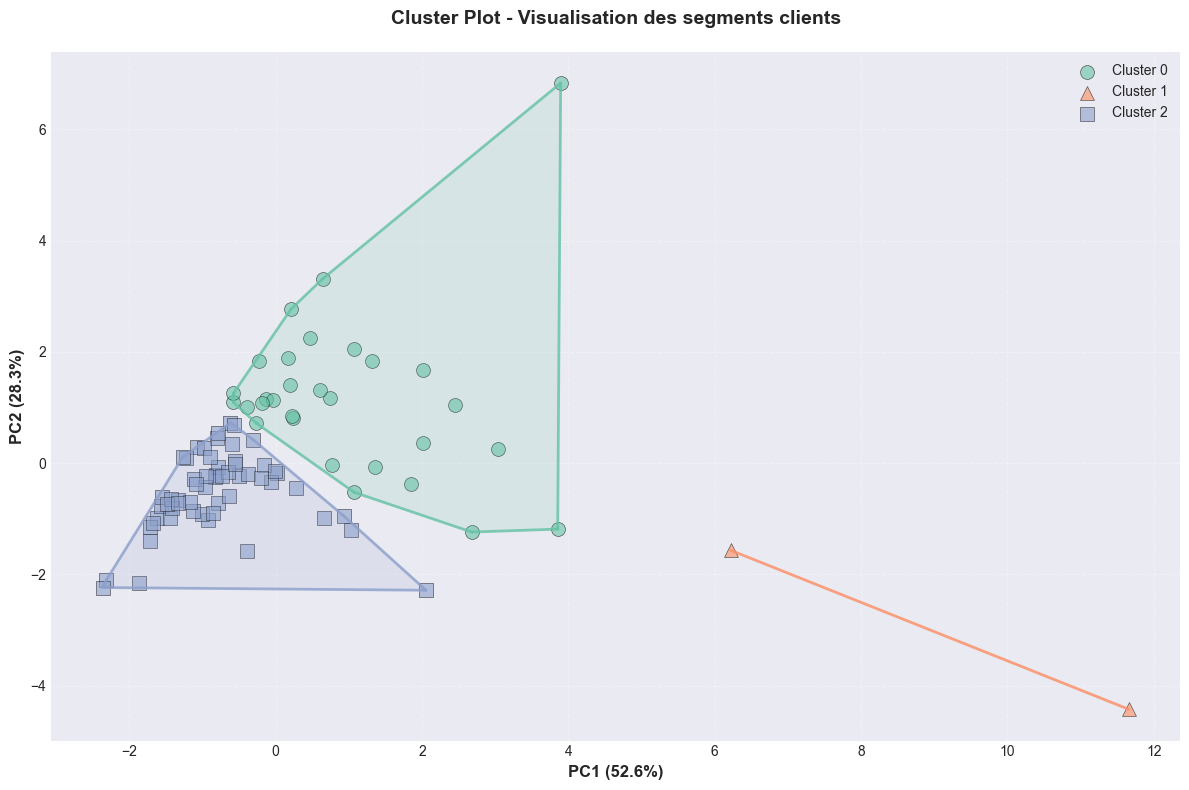


📊 Distribution des clusters:
   Cluster 0: 30 clients (33.7%)
   Cluster 1: 2 clients (2.2%)
   Cluster 2: 57 clients (64.0%)


In [27]:
# Visualisation avancée avec enveloppes convexes (Cluster Plot)
from scipy.spatial import ConvexHull

plt.figure(figsize=(12, 8))

# Palette de couleurs
colors = plt.cm.Set2(range(optimal_k))
markers = ['o', '^', 's', 'D', 'v', 'p', '*', 'h']

# Pour chaque cluster
for cluster_id in sorted(customer_data[cluster_column].unique()):
    # Filtrer les points du cluster
    cluster_mask = customer_data[cluster_column] == cluster_id
    cluster_points = X_pca_2d[cluster_mask]
    
    # Tracer les points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=[colors[cluster_id]], 
               marker=markers[cluster_id % len(markers)],
               s=100, 
               alpha=0.6,
               edgecolors='black',
               linewidth=0.5,
               label=f'Cluster {cluster_id}')
    
    # Créer l'enveloppe convexe si suffisamment de points
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            # Tracer l'enveloppe
            for simplex in hull.simplices:
                plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                        color=colors[cluster_id], linewidth=2, alpha=0.8)
            # Remplir l'enveloppe
            hull_points = cluster_points[hull.vertices]
            hull_points = np.vstack([hull_points, hull_points[0]])  # Fermer le polygone
            plt.fill(hull_points[:, 0], hull_points[:, 1], 
                    color=colors[cluster_id], alpha=0.15)
        except:
            # Si l'enveloppe convexe échoue (points colinéaires), on skip
            pass
    elif len(cluster_points) == 2:
        # Pour 2 points, tracer juste une ligne
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[cluster_id], linewidth=2, alpha=0.8)

# Configuration du graphique
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=12, fontweight='bold')
plt.title('Cluster Plot - Visualisation des segments clients', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Afficher la distribution
print("\n📊 Distribution des clusters:")
for cluster_id in sorted(customer_data[cluster_column].unique()):
    count = (customer_data[cluster_column] == cluster_id).sum()
    pct = count / len(customer_data) * 100
    print(f"   Cluster {cluster_id}: {count} clients ({pct:.1f}%)")

In [28]:
# Visualisation 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

viz_df_3d = pd.DataFrame({
    'PC1': X_pca_3d[:, 0],
    'PC2': X_pca_3d[:, 1],
    'PC3': X_pca_3d[:, 2],
    'Cluster': customer_data[cluster_column].astype(str),
    'CustomerID': customer_data['customerID'].values,
    'Recency': customer_data['recency'].values,
    'Frequency': customer_data['frequency'].values,
    'Monetary': customer_data['monetary'].values
})

fig_3d = px.scatter_3d(viz_df_3d, x='PC1', y='PC2', z='PC3', color='Cluster',
                       hover_data=['CustomerID', 'Recency', 'Frequency', 'Monetary'],
                       title='Visualisation 3D des clusters (PCA)',
                       labels={'PC1': f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})',
                               'PC2': f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})',
                               'PC3': f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})'},
                       color_discrete_sequence=px.colors.qualitative.Set1)

fig_3d.update_traces(marker=dict(size=5, line=dict(width=0.3, color='white')))
fig_3d.update_layout(height=700)
fig_3d.show()

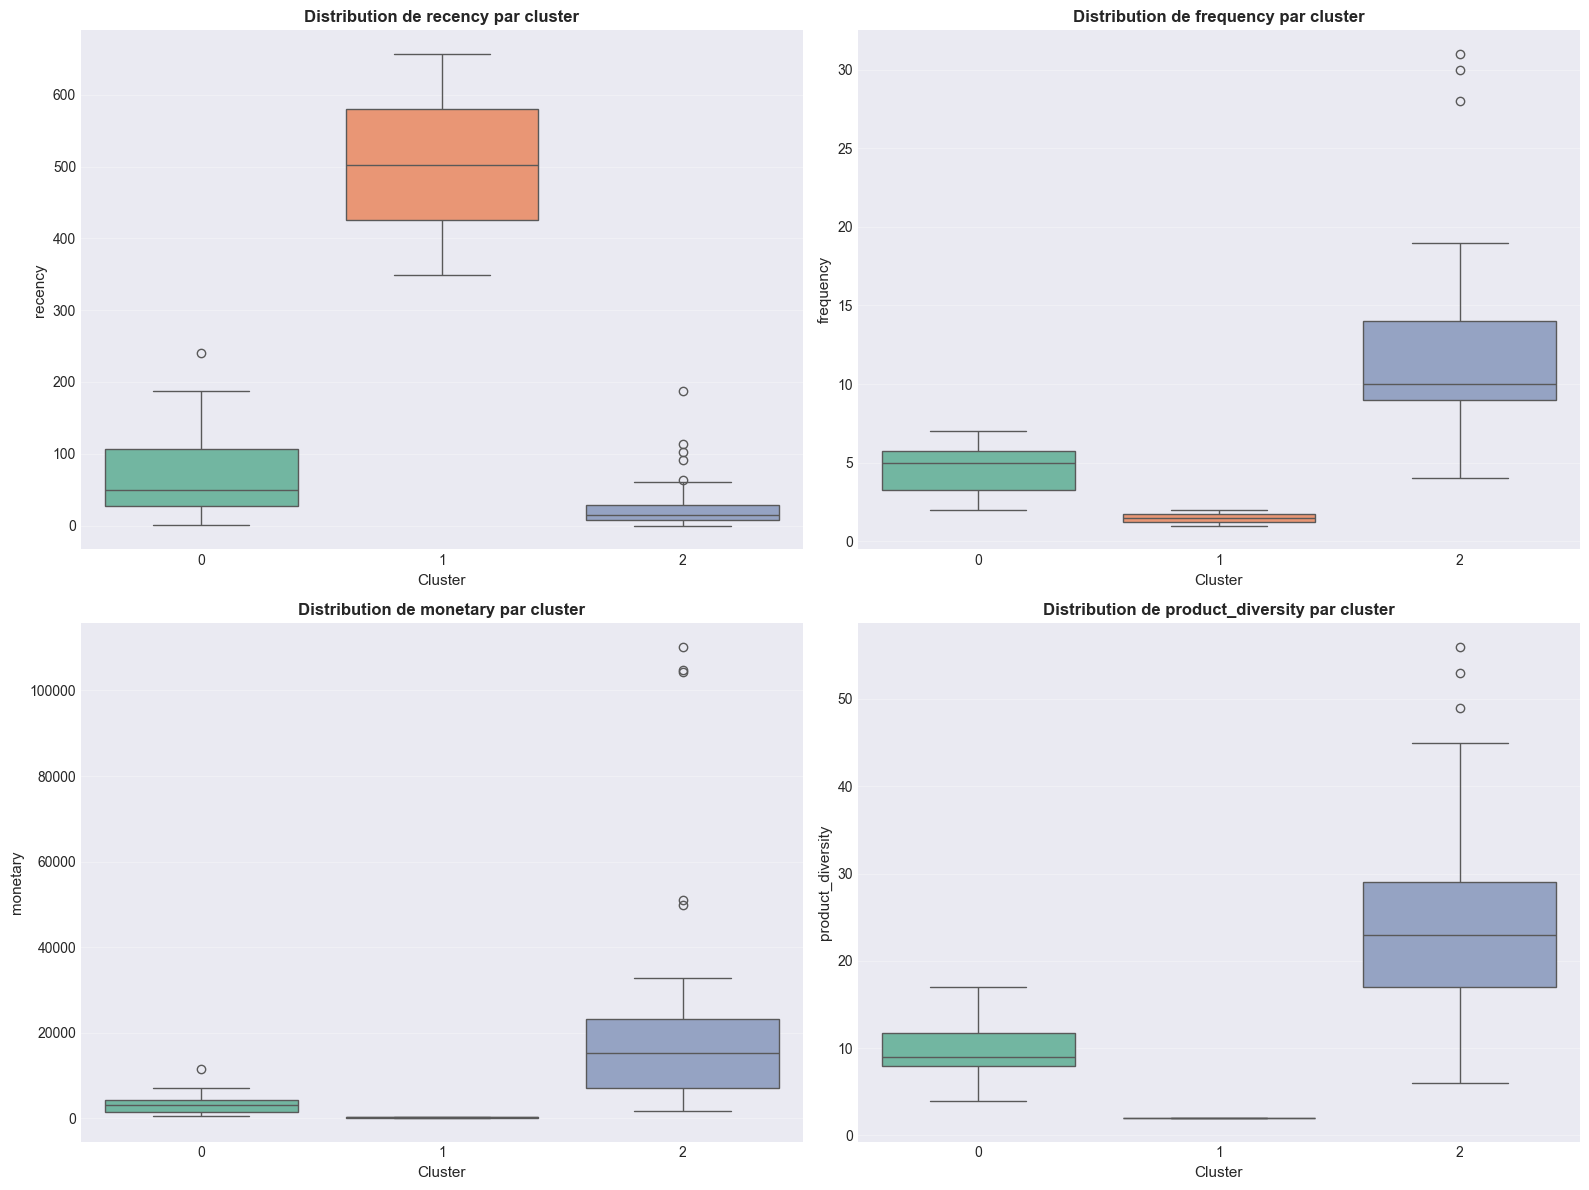

In [29]:
# Box plots par cluster pour les principales features
features_to_visualize = ['recency', 'frequency', 'monetary', 'product_diversity']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(features_to_visualize):
    sns.boxplot(data=customer_data, x=cluster_column, y=feature, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'Distribution de {feature} par cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster', fontsize=11)
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

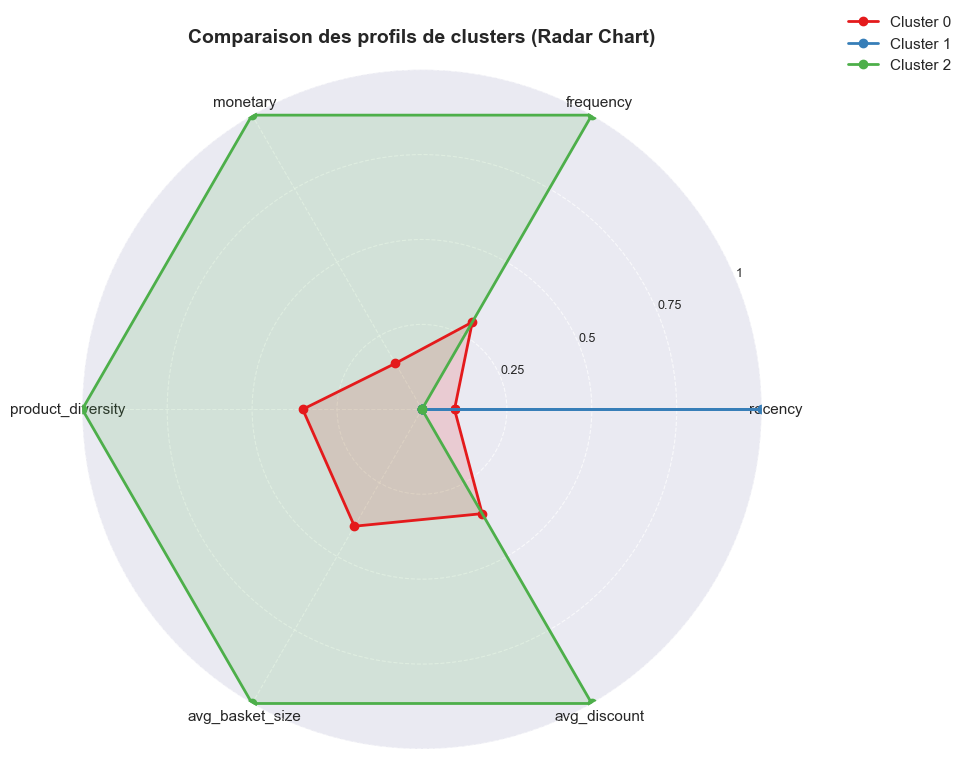

In [30]:
# Normalisation des profils pour le radar chart
cluster_profiles_norm = cluster_profiles.copy()
for col in cluster_profiles_norm.columns:
    min_val = cluster_profiles_norm[col].min()
    max_val = cluster_profiles_norm[col].max()
    if max_val - min_val != 0:
        cluster_profiles_norm[col] = (cluster_profiles_norm[col] - min_val) / (max_val - min_val)

# Sélection de features pour le radar
radar_features = ['recency', 'frequency', 'monetary', 'product_diversity', 'avg_basket_size', 'avg_discount']
radar_data = cluster_profiles_norm[radar_features]

# Nombre de variables
categories = radar_features
N = len(categories)

# Angles pour chaque axe
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialisation du plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot pour chaque cluster
colors = plt.cm.Set1(range(optimal_k))
for idx, cluster_id in enumerate(sorted(customer_data[cluster_column].unique())):
    values = radar_data.loc[cluster_id].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}', color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

# Configurations
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1])
ax.set_yticklabels(['0.25', '0.5', '0.75', '1'], size=9)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('Comparaison des profils de clusters (Radar Chart)', size=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 11. Clustering alternatif - DBSCAN

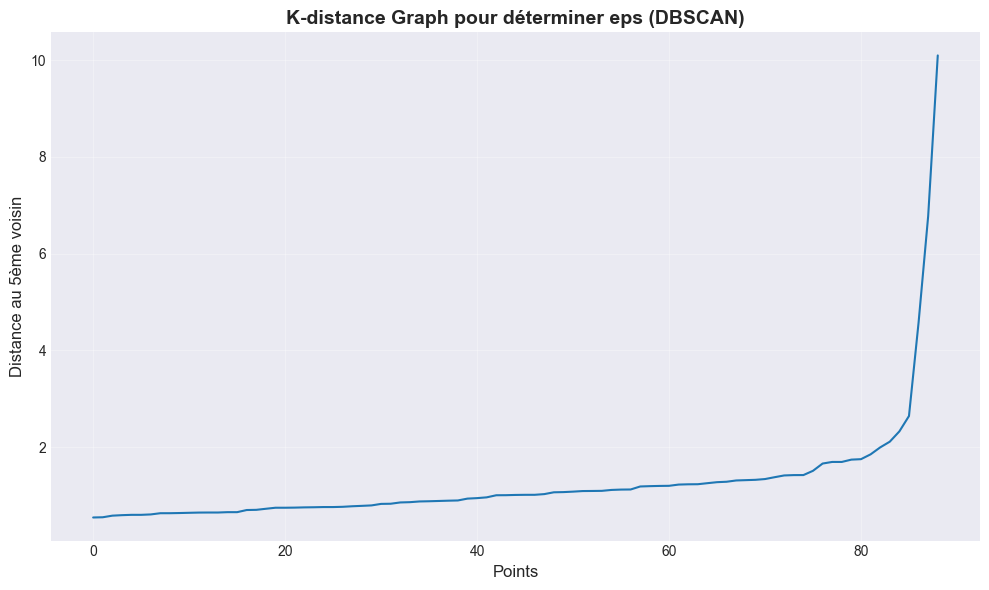

💡 Choisissez eps au niveau du 'coude' du graphique


In [31]:
# Détermination de eps avec k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points', fontsize=12)
plt.ylabel('Distance au 5ème voisin', fontsize=12)
plt.title('K-distance Graph pour déterminer eps (DBSCAN)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Choisissez eps au niveau du 'coude' du graphique")

In [32]:
# Application DBSCAN
eps_value = 2.5  # Ajustez selon le graphique ci-dessus
min_samples_value = 5

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters_dbscan = dbscan.fit_predict(X_scaled)

customer_data['cluster_dbscan'] = clusters_dbscan

print(f"\n✅ DBSCAN appliqué (eps={eps_value}, min_samples={min_samples_value})")
print(f"\n📊 Distribution des clusters DBSCAN:")
print(customer_data['cluster_dbscan'].value_counts().sort_index())
print(f"\nNombre de points de bruit (cluster -1): {(clusters_dbscan == -1).sum()}")

# Score si on a au moins 2 clusters (hors bruit)
if len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0) >= 2:
    # Exclure le bruit pour le score
    mask = clusters_dbscan != -1
    if mask.sum() > 0:
        silhouette_dbscan = silhouette_score(X_scaled[mask], clusters_dbscan[mask])
        print(f"\n📈 Silhouette Score (DBSCAN, sans bruit): {silhouette_dbscan:.3f}")


✅ DBSCAN appliqué (eps=2.5, min_samples=5)

📊 Distribution des clusters DBSCAN:
cluster_dbscan
-1     3
 0    86
Name: count, dtype: int64

Nombre de points de bruit (cluster -1): 3


## 13. Comparaison des méthodes de clustering

## 14. Sauvegarde du modèle et des résultats

In [ ]:
# Créer un dossier pour les modèles
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

# Sauvegarde du meilleur modèle (K-Means sur données normalisées)
model_artifacts = {
    'kmeans_model': kmeans_scaled,
    'scaler': scaler,
    'pca': pca,
    'feature_columns': selected_features,  # CORRECTION: utiliser selected_features au lieu de feature_columns
    'n_clusters': optimal_k,
    'cluster_profiles': cluster_profiles,
    'pca_2d': pca_2d  # Pour visualisation
}

joblib.dump(model_artifacts, models_dir / 'customer_clustering_model.pkl')
print("✅ Modèle sauvegardé dans models/customer_clustering_model.pkl")

# Sauvegarde des résultats
results_df = customer_data[['customerID', 'cluster_scaled', 'recency', 'frequency', 'monetary']].copy()
results_df.columns = ['customerID', 'cluster', 'recency', 'frequency', 'monetary']

# Ajout des profils textuels
cluster_labels = {
    # Ces labels sont à personnaliser selon vos clusters
    0: 'Champions',
    1: 'Loyal Customers',
    2: 'At Risk',
    3: 'Lost Customers'
}

# Ajustez les labels selon votre interprétation
results_df['cluster_label'] = results_df['cluster'].map(cluster_labels)

results_df.to_csv(ENRICHED_DIR / 'customer_clusters.csv', index=False)
print(f"✅ Résultats sauvegardés dans {ENRICHED_DIR / 'customer_clusters.csv'}")

print("\n📊 Aperçu des résultats:")
display(results_df.head(10))

✅ Modèle sauvegardé dans models/customer_clustering_model.pkl
✅ Résultats sauvegardés dans data\enriched\customer_clusters.csv

📊 Aperçu des résultats:


,customerID,cluster,recency,frequency,monetary,cluster_label
0,ALFKI,2,27,6,4273.0000,At Risk
1,ANATR,0,63,4,1402.9500,Champions
2,ANTON,0,98,7,7023.9775,Champions
3,AROUT,2,26,13,13390.6500,At Risk
4,BERGS,2,63,18,24927.5775,At Risk
5,BLAUS,2,7,7,3239.8000,At Risk
6,BLONP,2,114,11,18534.0800,At Risk
7,BOLID,0,43,3,4232.8500,Champions
8,BONAP,2,0,17,21963.2525,At Risk
9,BOTTM,2,12,14,20801.6000,At Risk


## 15. Fonction de prédiction pour nouveaux clients

In [36]:
def predict_customer_cluster(customer_features_dict, model_path='models/customer_clustering_model.pkl'):
    """
    Prédit le cluster d'un nouveau client.
    
    Parameters:
    -----------
    customer_features_dict : dict
        Dictionnaire avec les features du client
        Ex: {'recency': 30, 'frequency': 8, 'monetary': 3000, ...}
    model_path : str
        Chemin vers le modèle sauvegardé
        
    Returns:
    --------
    cluster_id : int
        ID du cluster prédit
    """
    # Charger le modèle
    artifacts = joblib.load(model_path)
    
    # Extraire les composants
    kmeans = artifacts['kmeans_model']
    scaler = artifacts['scaler']
    feature_cols = artifacts['feature_columns']
    
    # Créer un DataFrame avec les features
    customer_df = pd.DataFrame([customer_features_dict])
    
    # Appliquer la transformation log à monetary si nécessaire
    if 'monetary_log' in feature_cols and 'monetary' in customer_df.columns:
        customer_df['monetary_log'] = np.log1p(customer_df['monetary'])
    
    # Sélectionner les features dans le bon ordre
    customer_df = customer_df[feature_cols]
    
    # Normaliser
    customer_scaled = scaler.transform(customer_df)
    
    # Prédire
    cluster = kmeans.predict(customer_scaled)[0]
    
    return cluster

# Test de la fonction
# Note: ne mettre que les features nécessaires (monetary sera automatiquement converti en monetary_log)
test_customer = {
    'recency': 15,
    'frequency': 12,
    'monetary': 5000,  # Sera automatiquement converti en monetary_log
    'avg_discount': 0.05,
    'avg_days_between_orders': 25,
    'recent_ratio': 0.42
}

predicted_cluster = predict_customer_cluster(test_customer)
print(f"\n🎯 Cluster prédit pour le client test: {predicted_cluster}")


🎯 Cluster prédit pour le client test: 2


## 16. Résumé et recommandations

In [38]:
print("="*80)
print("RÉSUMÉ DE L'ANALYSE DE CLUSTERING")
print("="*80)

print(f"\n📊 Données analysées:")
print(f"   - Nombre de clients: {len(customer_data)}")
print(f"   - Nombre de features: {len(selected_features)}")
print(f"   - Features: {', '.join(selected_features)}")

print(f"\n🎯 Clustering optimal:")
print(f"   - Algorithme: K-Means")
print(f"   - Nombre de clusters: {optimal_k}")
print(f"   - Silhouette Score: {silhouette_score(X_scaled, clusters_scaled):.3f}")

# Définir les labels des clusters
cluster_labels = {
    0: 'Low-Value Inactive',
    1: 'Lost Customers',
    2: 'VIP Premium'
}

print(f"\n📈 Distribution des clients:")
for cluster_id in sorted(customer_data['cluster_scaled'].unique()):
    count = (customer_data['cluster_scaled'] == cluster_id).sum()
    pct = count / len(customer_data) * 100
    label = cluster_labels.get(cluster_id, f'Cluster {cluster_id}')
    print(f"   - {label}: {count} clients ({pct:.1f}%)")

print(f"\n💾 Fichiers générés:")
print(f"   - Modèle: models/customer_clustering_model.pkl")
print(f"   - Résultats: data/enriched/customer_clusters.csv")

print(f"\n🚀 Prochaines étapes pour intégration dans Dash:")
print(f"   1. Charger le modèle et les résultats dans votre application Dash")
print(f"   2. Créer des visualisations interactives des clusters")
print(f"   3. Ajouter un onglet 'Segmentation Client' au dashboard")
print(f"   4. Permettre la prédiction en temps réel pour nouveaux clients")
print(f"   5. Ajouter des recommandations marketing par segment")

print("\n" + "="*80)

RÉSUMÉ DE L'ANALYSE DE CLUSTERING

📊 Données analysées:
   - Nombre de clients: 89
   - Nombre de features: 6
   - Features: recency, frequency, monetary_log, avg_discount, avg_days_between_orders, recent_ratio

🎯 Clustering optimal:
   - Algorithme: K-Means
   - Nombre de clusters: 3
   - Silhouette Score: 0.308

📈 Distribution des clients:
   - Low-Value Inactive: 30 clients (33.7%)
   - Lost Customers: 2 clients (2.2%)
   - VIP Premium: 57 clients (64.0%)

💾 Fichiers générés:
   - Modèle: models/customer_clustering_model.pkl
   - Résultats: data/enriched/customer_clusters.csv

🚀 Prochaines étapes pour intégration dans Dash:
   1. Charger le modèle et les résultats dans votre application Dash
   2. Créer des visualisations interactives des clusters
   3. Ajouter un onglet 'Segmentation Client' au dashboard
   4. Permettre la prédiction en temps réel pour nouveaux clients
   5. Ajouter des recommandations marketing par segment



## 📝 Notes et observations

**Points clés à retenir:**

1. **Features engineering**: Les features RFM sont complétées par des métriques comportementales (diversité produits, panier moyen, etc.)

2. **PCA**: Permet de réduire la dimensionnalité tout en conservant l'essentiel de l'information (80-90% de variance)

3. **Choix de K**: Plusieurs méthodes convergent vers un nombre optimal de clusters

4. **Interprétabilité**: Chaque cluster a un profil distinct et interprétable pour le business

5. **Production**: Le modèle est sauvegardé et peut être utilisé pour scorer de nouveaux clients

**Recommandations:**
- Réévaluer le modèle périodiquement (ex: trimestriellement)
- Adapter les stratégies marketing selon les segments
- Surveiller les migrations de clients entre clusters